In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, make_scorer

import gc
import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

#### 1. Для каждой из шести задач прогнозирования сформируйте выборки

In [2]:
# загрузка аггрегированных значений с 2013 по 2016 гг (по июнь включительно) по 102 регионам
result_102 = pd.read_csv('result_102.csv', index_col='region')

In [3]:
result_102_T = result_102.T

In [4]:
result_102_T

region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-01-01 00:00:00,75.0,149.0,88.0,95.0,297.0,538.0,594.0,769.0,952.0,267.0,...,12.0,0.0,9.0,113.0,27.0,19.0,6.0,68.0,18.0,67.0
2013-01-01 01:00:00,108.0,204.0,81.0,126.0,402.0,572.0,518.0,623.0,655.0,220.0,...,22.0,0.0,3.0,7.0,5.0,11.0,3.0,82.0,1.0,15.0
2013-01-01 02:00:00,82.0,162.0,83.0,135.0,361.0,471.0,470.0,495.0,484.0,156.0,...,23.0,0.0,1.0,6.0,3.0,2.0,0.0,28.0,0.0,16.0
2013-01-01 03:00:00,79.0,122.0,24.0,106.0,289.0,482.0,448.0,467.0,337.0,102.0,...,25.0,0.0,1.0,1.0,7.0,2.0,0.0,6.0,0.0,1.0
2013-01-01 04:00:00,35.0,89.0,20.0,59.0,181.0,332.0,377.0,343.0,354.0,92.0,...,26.0,0.0,2.0,5.0,2.0,3.0,0.0,30.0,2.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,116.0,190.0,135.0,132.0,395.0,308.0,401.0,336.0,496.0,260.0,...,2.0,44.0,4.0,297.0,311.0,104.0,9.0,142.0,96.0,1.0
2016-06-30 20:00:00,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0
2016-06-30 21:00:00,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2016-06-30 22:00:00,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0


In [5]:
result_102_T.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30646 entries, 2013-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 102 entries, 1075 to 2168
dtypes: float64(102)
memory usage: 25.3+ MB


In [6]:
# Создадим общие категориальные признаки для всех регионов:
common_cat_features = pd.DataFrame()
common_cat_features['date'] = pd.to_datetime(result_102_T.index) # привели к временному формату, чтобы извлекать признаки

# год, месяц, день месяца, день недели, час — создаем эти признаки:
common_cat_features['year'] = common_cat_features['date'].dt.year
common_cat_features['month'] = common_cat_features['date'].dt.month
common_cat_features['weekday'] = common_cat_features['date'].dt.weekday
common_cat_features['day'] = common_cat_features['date'].dt.day
common_cat_features['hour'] = common_cat_features['date'].dt.hour


In [7]:
common_cat_features

,date,year,month,weekday,day,hour
0,2013-01-01 00:00:00,2013,1,1,1,0
1,2013-01-01 01:00:00,2013,1,1,1,1
2,2013-01-01 02:00:00,2013,1,1,1,2
3,2013-01-01 03:00:00,2013,1,1,1,3
4,2013-01-01 04:00:00,2013,1,1,1,4
...,...,...,...,...,...,...
30641,2016-06-30 19:00:00,2016,6,3,30,19
30642,2016-06-30 20:00:00,2016,6,3,30,20
30643,2016-06-30 21:00:00,2016,6,3,30,21
30644,2016-06-30 22:00:00,2016,6,3,30,22


In [8]:
common_cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30646 entries, 0 to 30645
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     30646 non-null  datetime64[ns]
 1   year     30646 non-null  int64         
 2   month    30646 non-null  int64         
 3   weekday  30646 non-null  int64         
 4   day      30646 non-null  int64         
 5   hour     30646 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.4 MB


In [9]:
# создание регрессионного признака для годовой и  еженедельной  сезонности
# по всему временному диапазону (с 2013-01-01 по 2016-06-30) и по нашим уже рассчитанным данным по кол-ву sin и cos на 4ой неделе:
# Для годовой сезонности значение параметра К1 = 53
# Для недельной сезонности значение параметра К2 = 36

K1 = 53
K2 = 36

s_c = pd.DataFrame()

length = result_102.shape[1]
s_c['s_0'] = np.arange(1, length+1)
for i in range(1, K1+1):
    s_c['s_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/8766)
    s_c['c_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/8766)

for i in range(1, K2+1):
    s_c['ss_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/168)
    s_c['cc_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/168)       
X_s_c = s_c.copy() 


In [10]:
#  Обьединим общие категориальные и регрессионные признаки:
common_features = pd.concat([common_cat_features, X_s_c], axis=1)

In [11]:
common_features

,date,year,month,weekday,day,hour,s_0,s_1,c_1,s_2,...,ss_32,cc_32,ss_33,cc_33,ss_34,cc_34,ss_35,cc_35,ss_36,cc_36
0,2013-01-01 00:00:00,2013,1,1,1,0,1,0.000717,1.000000,0.001434,...,0.930874,0.365341,0.943883,3.302791e-01,0.955573,0.294755,0.965926,2.588190e-01,9.749279e-01,0.222521
1,2013-01-01 01:00:00,2013,1,1,1,1,2,0.001434,0.999999,0.002867,...,0.680173,-0.733052,0.623490,-7.818315e-01,0.563320,-0.826239,0.500000,-8.660254e-01,4.338837e-01,-0.900969
2,2013-01-01 02:00:00,2013,1,1,1,2,3,0.002150,0.999998,0.004301,...,-0.433884,-0.900969,-0.532032,-8.467242e-01,-0.623490,-0.781831,-0.707107,-7.071068e-01,-7.818315e-01,-0.623490
3,2013-01-01 03:00:00,2013,1,1,1,3,4,0.002867,0.999996,0.005734,...,-0.997204,0.074730,-0.974928,2.225209e-01,-0.930874,0.365341,-0.866025,5.000000e-01,-7.818315e-01,0.623490
4,2013-01-01 04:00:00,2013,1,1,1,4,5,0.003584,0.999994,0.007168,...,-0.294755,0.955573,-0.111964,9.937122e-01,0.074730,0.997204,0.258819,9.659258e-01,4.338837e-01,0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30641,2016-06-30 19:00:00,2016,6,3,30,19,30642,0.027950,-0.999609,-0.055879,...,-0.433884,-0.900969,-0.222521,9.749279e-01,0.781831,-0.623490,-1.000000,-4.782138e-13,7.818315e-01,0.623490
30642,2016-06-30 20:00:00,2016,6,3,30,20,30643,0.027234,-0.999629,-0.054447,...,-0.997204,0.074730,0.846724,5.320321e-01,-0.365341,-0.930874,-0.258819,9.659258e-01,7.818315e-01,-0.623490
30643,2016-06-30 21:00:00,2016,6,3,30,21,30644,0.026517,-0.999648,-0.053016,...,-0.294755,0.955573,0.781831,-6.234898e-01,-0.997204,0.074730,0.866025,5.000000e-01,-4.338837e-01,-0.900969
30644,2016-06-30 22:00:00,2016,6,3,30,22,30645,0.025801,-0.999667,-0.051584,...,0.781831,0.623490,-0.330279,-9.438833e-01,-0.222521,0.974928,0.707107,-7.071068e-01,-9.749279e-01,0.222521


In [12]:
common_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30646 entries, 0 to 30645
Columns: 185 entries, date to cc_36
dtypes: datetime64[ns](1), float64(178), int32(1), int64(5)
memory usage: 43.1 MB


In [13]:
# количество поездок из рассматриваемого района в моменты времени sum_k и суммарного кол-ва за sum_n
private_features_all = {}
private_features = pd.DataFrame()
result_102_T_reset = result_102_T.copy().reset_index(drop=True)

for region in result_102_T.columns:
    private_features = pd.DataFrame()
    
    sum_k = [1, 2, 3, 4, 5, 6, 24, 48] # задаем смещения
    sum_n = [12, 24, 168]              # задаем суммы за пред. периоды
    
    for k in sum_k:
            private_features['shift_' + str(k)] = result_102_T_reset[region].shift(k)  
    for n in sum_n:
        private_features['sum_' + str(n)] = result_102_T_reset[region].rolling(window=n).sum().shift(1)
        
    private_features_all[region] = private_features   # сюда записываются данные по всем регионам

In [ ]:
private_features_all[region].info()

In [ ]:
private_features_all[1075]

In [ ]:
private_features.columns

#### 2. Разбейте каждую из шести выборок на три части:
- обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
- тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
- итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

In [48]:
# Разбиение данных
y_result_102_T_drop = result_102_T[sum_n[-1]:] #  дропаем строки, ктр заполнены NaN за счет максимального смещения

predict_may_start= '2016-05-01 00:00:00'
predict_may_stop = '2016-05-31 18:00:00'

predict_june_start= '2016-06-01 00:00:00'
predict_june_stop = '2016-06-30 18:00:00'

#### 3. Выберите регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:
- допускала попарные взаимодействия между признаками
- была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

In [18]:
# указываем колонки для трансформации:
numerical_features_1 = private_features.columns  # только для этих колонок будем производить PolynomialFeatures 
numerical_features_2 = X_s_c.columns
categorical_features = common_cat_features.select_dtypes(include=['int64']).columns

# указываем какой препроцессинг будем делать на разных колонках (параметры скалирования зададим непосредств.в grid_search):
numerical_transformer_1 = Pipeline(steps=[
    ('poly', PolynomialFeatures(interaction_only=True,include_bias = False)),
    ('scaler', 'passthrough')])
numerical_transformer_2 = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

# создаем общий трансформатор:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical_1', numerical_transformer_1, numerical_features_1),
        ('numerical_2', numerical_transformer_2, numerical_features_2),
        ('categorical', categorical_transformer, categorical_features)])

In [19]:
# В качестве регрессии берем ElasticNet, ктр учитывает и L1 и L2 регуляризаторы

# создаем pipline для ElasticNet:
en = Pipeline(steps=[('preprocessor', data_transformer),
                      ('ElasticNet', ElasticNet(random_state=42, max_iter=1000))])

In [20]:
# Создаем сетку поиска
param_grid = {
    'preprocessor__numerical_1__scaler': [StandardScaler()],
    'ElasticNet__alpha': np.linspace(0.01, 0.3, num = 15),
    'ElasticNet__l1_ratio': np.linspace(0, 1, num = 5),
}

#### поиск по сетке с предварительной оценкой:

In [21]:
cum_best_params = {} # создаем dict для записи best_params 

sum_may = 0
for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Создадим валидационную часть для GridSearchCV 
    # Split Data to Train and Validationf

    X_train = features_all[value][features_all[value].date < predict_may_start]
    X_val = features_all[value][(features_all[value].date >= predict_may_start) & (features_all[value].date < predict_may_stop)]
    X = pd.concat([X_train, X_val])

    # Создаем маску для ЕДИНИЧНОЙ кроссвалидации:

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val.shape[0])]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)


    grid_search = GridSearchCV(en, param_grid=param_grid, cv=pds)

    y_train = y_result_102_T_drop[value][:predict_may_start]
    y_train_for_shift = y_train.copy()

    for ii in range(0, 7):
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(grid_search.best_estimator_.predict(X_val[0:1]))]).shift(-1)[:-1]
            
            # Решение для суммирования!!!
            sum_time = np.sum(abs(grid_search.best_estimator_.predict(X_val) - y_val))
            sum_may += sum_time
            
        y_train = y_train_for_shift
        y_val  = y_result_102_T_drop[value].shift(-ii)[predict_may_start: predict_may_stop] # валидационные цели со смещением
        y = pd.concat([y_train, y_val])
        
        
        
        
        # Тренируем модель
        grid_search.fit(X, y)
        
        cum_best_params[str(value)+'_' + str(ii)] = grid_search.best_params_
        print('region=' + str(value)+'_hour_' + str(ii) + '  best_score =', grid_search.best_score_)
        
sum_may = 1/(102*739*6)*sum_may
print('Ошибка прогноза за май', sum_may) # Предварительная оценка смотрит в будущее,т.к. refit не отключен, - особо внимание на нее не обращайте))

region=1075_hour_0  best_score = 0.9041360870551183
region=1075_hour_1  best_score = 0.8813716443497064
region=1075_hour_2  best_score = 0.8635058133095697
region=1075_hour_3  best_score = 0.8522063402511765
region=1075_hour_4  best_score = 0.8436588783367557
region=1075_hour_5  best_score = 0.8415493194575473
region=1075_hour_6  best_score = 0.8403473267780619
region=1076_hour_0  best_score = 0.9460577006863412
region=1076_hour_1  best_score = 0.9173354772995883
region=1076_hour_2  best_score = 0.9024917691768061
region=1076_hour_3  best_score = 0.8952285685548454
region=1076_hour_4  best_score = 0.8959558011058749
region=1076_hour_5  best_score = 0.8962053897937947
region=1076_hour_6  best_score = 0.8956270233180714
region=1077_hour_0  best_score = 0.9284434438976812
region=1077_hour_1  best_score = 0.8948459749930777
region=1077_hour_2  best_score = 0.8749981015793741
region=1077_hour_3  best_score = 0.866797120712749
region=1077_hour_4  best_score = 0.8652129357370776
region=1077_h

region=1183_hour_4  best_score = 0.5984747362914018
region=1183_hour_5  best_score = 0.5948222228780944
region=1183_hour_6  best_score = 0.5908166263503483
region=1184_hour_0  best_score = 0.8077562669101126
region=1184_hour_1  best_score = 0.7791391079946165
region=1184_hour_2  best_score = 0.7672375524971475
region=1184_hour_3  best_score = 0.7587207037318642
region=1184_hour_4  best_score = 0.7535269679946919
region=1184_hour_5  best_score = 0.7516808037040136
region=1184_hour_6  best_score = 0.7525982268076519
region=1221_hour_0  best_score = 0.5908005779122001
region=1221_hour_1  best_score = 0.4934865636225132
region=1221_hour_2  best_score = 0.4397989438256381
region=1221_hour_3  best_score = 0.41108481420550413
region=1221_hour_4  best_score = 0.3984291937823704
region=1221_hour_5  best_score = 0.38695098629035574
region=1221_hour_6  best_score = 0.3771885961312733
region=1222_hour_0  best_score = 0.7644854385143581
region=1222_hour_1  best_score = 0.6995231562480728
region=122

region=1282_hour_1  best_score = 0.9547063242441752
region=1282_hour_2  best_score = 0.9390301744478731
region=1282_hour_3  best_score = 0.9246650886141364
region=1282_hour_4  best_score = 0.9172193954358714
region=1282_hour_5  best_score = 0.9141732190826323
region=1282_hour_6  best_score = 0.9152864087561978
region=1283_hour_0  best_score = 0.9509076627227628
region=1283_hour_1  best_score = 0.9190097386675626
region=1283_hour_2  best_score = 0.9003187137944981
region=1283_hour_3  best_score = 0.8919788328358411
region=1283_hour_4  best_score = 0.8897320445388376
region=1283_hour_5  best_score = 0.887809070618846
region=1283_hour_6  best_score = 0.8872876518648883
region=1284_hour_0  best_score = 0.9240334973808139
region=1284_hour_1  best_score = 0.9004387180201818
region=1284_hour_2  best_score = 0.8912822169476349
region=1284_hour_3  best_score = 0.8851842220463711
region=1284_hour_4  best_score = 0.8828842990228952
region=1284_hour_5  best_score = 0.8821150621363
region=1284_hour

region=1383_hour_5  best_score = 0.910949313056359
region=1383_hour_6  best_score = 0.9058940464258245
region=1384_hour_0  best_score = 0.9488675474337614
region=1384_hour_1  best_score = 0.9177652094731283
region=1384_hour_2  best_score = 0.9086487036408325
region=1384_hour_3  best_score = 0.8992152625134058
region=1384_hour_4  best_score = 0.8894409116561239
region=1384_hour_5  best_score = 0.8817652474865451
region=1384_hour_6  best_score = 0.8755204321417006
region=1385_hour_0  best_score = 0.9497873626622831
region=1385_hour_1  best_score = 0.9301307865770068
region=1385_hour_2  best_score = 0.9222175878849064
region=1385_hour_3  best_score = 0.9164788144499936
region=1385_hour_4  best_score = 0.9134093213812826
region=1385_hour_5  best_score = 0.9081936528114714
region=1385_hour_6  best_score = 0.9049616295512529
region=1386_hour_0  best_score = 0.7883389895308094
region=1386_hour_1  best_score = 0.7441291668012643
region=1386_hour_2  best_score = 0.7205482157704268
region=1386_h

region=1533_hour_2  best_score = 0.7084223833909293
region=1533_hour_3  best_score = 0.6993323838012973
region=1533_hour_4  best_score = 0.6878571699227148
region=1533_hour_5  best_score = 0.6841818817911336
region=1533_hour_6  best_score = 0.6836433714233923
region=1580_hour_0  best_score = 0.7618937803679529
region=1580_hour_1  best_score = 0.7284288539987542
region=1580_hour_2  best_score = 0.7194021917144645
region=1580_hour_3  best_score = 0.7139210951357284
region=1580_hour_4  best_score = 0.7137328316241214
region=1580_hour_5  best_score = 0.7130044559021698
region=1580_hour_6  best_score = 0.712302988959469
region=1630_hour_0  best_score = 0.6276128064910038
region=1630_hour_1  best_score = 0.6054579587898015
region=1630_hour_2  best_score = 0.6038025273321288
region=1630_hour_3  best_score = 0.5997442105494237
region=1630_hour_4  best_score = 0.597368451929492
region=1630_hour_5  best_score = 0.5876634264555538
region=1630_hour_6  best_score = 0.5846647106891232
region=1684_ho

In [22]:
cum_best_params

{'1075_0': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_1': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_2': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_3': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_4': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_5': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1075_6': {'ElasticNet__alpha': 0.01,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__numerical_1__scaler': StandardScaler()},
 '1076_0': {'ElasticNet__alpha': 0.030714285714285715,
  'ElasticNet__l1_ratio': 1.0,
  'preprocessor__n

In [23]:
# Сохранение cum_best_params 

with open('cum_best_params_5_5.pkl', 'wb') as fp:
    pickle.dump(cum_best_params, fp)

#### 4. Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза. Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу QQ, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA.

In [24]:
sum_may_Re = 0

for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Split Data to Train and test

    X_train = features_all[value][features_all[value].date < predict_may_start]
    X_test = features_all[value][(features_all[value].date >= predict_may_start) & (features_all[value].date < predict_may_stop)]

    y_train = y_result_102_T_drop[value][:predict_may_start]
    y_train_for_shift = y_train.copy()

    for ii in range(0, 7):
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(en.predict(X_test[0:1]))]).shift(-1)[:-1]
            
            # Решение для суммирования!!!
            sum_time = np.sum(abs(en.predict(X_test) - y_test))
            sum_may_Re += sum_time
            
        y_train = y_train_for_shift
        y_test  = y_result_102_T_drop[value].shift(-ii)[predict_may_start: predict_may_stop] # test со смещением
                  
        # Тренируем модель с рассчитанными параметрами на предыдущем шаге!!:
        
        en.set_params(**cum_best_params[str(value)+'_' + str(ii)])
        en.fit(X_train, y_train)
        
        print('region=' + str(value)+'_hour_' + str(ii) + '  score =', en.score(X_test, y_test))
        
sum_may_Re = 1/(102*739*6)*sum_may_Re
print('Ошибка прогноза за май', sum_may_Re)

region=1075_hour_0  score = 0.9041360870551183
region=1075_hour_1  score = 0.8813706102477942
region=1075_hour_2  score = 0.8635019558654314
region=1075_hour_3  score = 0.8521994358686408
region=1075_hour_4  score = 0.8436515189330291
region=1075_hour_5  score = 0.8415514725568567
region=1075_hour_6  score = 0.8403546869907246
region=1076_hour_0  score = 0.9460577006863412
region=1076_hour_1  score = 0.9173353388207252
region=1076_hour_2  score = 0.9024909599401228
region=1076_hour_3  score = 0.8952280987423374
region=1076_hour_4  score = 0.8959552015814495
region=1076_hour_5  score = 0.8962044027449164
region=1076_hour_6  score = 0.8956259353901797
region=1077_hour_0  score = 0.9284434438976812
region=1077_hour_1  score = 0.8948458210595566
region=1077_hour_2  score = 0.8749980921164526
region=1077_hour_3  score = 0.866797005996365
region=1077_hour_4  score = 0.8652127705463353
region=1077_hour_5  score = 0.8637828112651866
region=1077_hour_6  score = 0.8650682164262888
region=1125_ho

region=1222_hour_0  score = 0.7644854385143581
region=1222_hour_1  score = 0.6995241290716583
region=1222_hour_2  score = 0.6521672395263306
region=1222_hour_3  score = 0.6387561420606082
region=1222_hour_4  score = 0.6142740365139623
region=1222_hour_5  score = 0.6010330269717485
region=1222_hour_6  score = 0.5915738828247215
region=1223_hour_0  score = 0.6989819546155713
region=1223_hour_1  score = 0.6424884959851613
region=1223_hour_2  score = 0.6072357132437238
region=1223_hour_3  score = 0.589925285348321
region=1223_hour_4  score = 0.5663862544943228
region=1223_hour_5  score = 0.5667385108617218
region=1223_hour_6  score = 0.5577649938113098
region=1224_hour_0  score = 0.7341292769332561
region=1224_hour_1  score = 0.6894319824055377
region=1224_hour_2  score = 0.6636802319711494
region=1224_hour_3  score = 0.651148091755427
region=1224_hour_4  score = 0.6428694736366785
region=1224_hour_5  score = 0.6374996748433394
region=1224_hour_6  score = 0.6227901202807085
region=1225_hou

region=1287_hour_0  score = 0.8919400355076961
region=1287_hour_1  score = 0.8629964320941943
region=1287_hour_2  score = 0.848985858826237
region=1287_hour_3  score = 0.842484095263329
region=1287_hour_4  score = 0.8386231857707291
region=1287_hour_5  score = 0.8345780077919224
region=1287_hour_6  score = 0.8291358078288993
region=1326_hour_0  score = 0.9127656852615018
region=1326_hour_1  score = 0.8552323846271089
region=1326_hour_2  score = 0.8027272615565539
region=1326_hour_3  score = 0.7752692925328831
region=1326_hour_4  score = 0.7644860149961935
region=1326_hour_5  score = 0.7551963242797075
region=1326_hour_6  score = 0.7498210385226629
region=1327_hour_0  score = 0.8645554370570401
region=1327_hour_1  score = 0.7123174529845366
region=1327_hour_2  score = 0.5950141538765669
region=1327_hour_3  score = 0.5052503193895933
region=1327_hour_4  score = 0.47257880434180344
region=1327_hour_5  score = 0.4591454999952048
region=1327_hour_6  score = 0.45094965341858273
region=1331_h

region=1426_hour_0  score = 0.8671460574325099
region=1426_hour_1  score = 0.8400340808665285
region=1426_hour_2  score = 0.8144493633405769
region=1426_hour_3  score = 0.8076615867787933
region=1426_hour_4  score = 0.8039448465441482
region=1426_hour_5  score = 0.7974473930357275
region=1426_hour_6  score = 0.7968459459505488
region=1431_hour_0  score = 0.3473942969216114
region=1431_hour_1  score = 0.2519136668000239
region=1431_hour_2  score = 0.24172585245221745
region=1431_hour_3  score = 0.2353769235341956
region=1431_hour_4  score = 0.2329079105226446
region=1431_hour_5  score = 0.23733335521537646
region=1431_hour_6  score = 0.22921182181517863
region=1434_hour_0  score = 0.7645443802274008
region=1434_hour_1  score = 0.7222782345801243
region=1434_hour_2  score = 0.7090012215968693
region=1434_hour_3  score = 0.6983222417365171
region=1434_hour_4  score = 0.6982906809503506
region=1434_hour_5  score = 0.6971413136589629
region=1434_hour_6  score = 0.6985048291865162
region=143

region=2119_hour_0  score = 0.695708176511487
region=2119_hour_1  score = 0.6143882091843809
region=2119_hour_2  score = 0.6245886070664866
region=2119_hour_3  score = 0.6181032365469132
region=2119_hour_4  score = 0.6143306675166409
region=2119_hour_5  score = 0.6103037779501193
region=2119_hour_6  score = 0.6025086550953341
region=2168_hour_0  score = 0.7420023559435162
region=2168_hour_1  score = 0.6692538813948794
region=2168_hour_2  score = 0.6651646766033901
region=2168_hour_3  score = 0.6704187696334727
region=2168_hour_4  score = 0.6749144346921524
region=2168_hour_5  score = 0.689877395424277
region=2168_hour_6  score = 0.6968488432741793
Ошибка прогноза за май 20.152239341313205


In [25]:
y_result_102_T_drop[value]

2013-01-08 00:00:00    52.0
2013-01-08 01:00:00    34.0
2013-01-08 02:00:00     4.0
2013-01-08 03:00:00     9.0
2013-01-08 04:00:00     9.0
                       ... 
2016-06-30 19:00:00     1.0
2016-06-30 20:00:00     0.0
2016-06-30 21:00:00     1.0
2016-06-30 22:00:00     0.0
2016-06-30 23:00:00     0.0
Name: 2168, Length: 30478, dtype: float64

In [26]:
print('Ошибка прогноза за май', sum_may_Re)

Ошибка прогноза за май 20.152239341313205


In [27]:
with open('cum_best_params_5_5.pkl', 'rb') as fp:
    cum_best_params = pickle.load(fp)

#### 5. Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [50]:
sum_june_Re = 0
kaggle = pd.DataFrame()

for value in result_102.index:

    features_all = {}
    features_all[value] = pd.concat([common_features, private_features_all[value]], axis=1).dropna().reset_index(drop=True)

    # Split Data to Train and test

    X_train = features_all[value][features_all[value].date < predict_june_start]
    X_test = features_all[value][(features_all[value].date >= predict_june_start) 
                                 & (features_all[value].date <= predict_june_stop)]

    y_train = y_result_102_T_drop[value][(y_result_102_T_drop[value].index < predict_june_start)]
    y_train_for_shift = y_train.copy()
    
    

    for ii in range(0, 6):
        
        y_test  = y_result_102_T_drop[value].shift(-ii)[predict_june_start: predict_june_stop] # test со смещением
        
        if ii >= 1:      
            y_train_for_shift = pd.concat([y_train_for_shift, pd.Series(en.predict(X_test[0:1]))]).shift(-1)[:-1]
            
        # Тренируем модель с рассчитанными параметрами на предыдущем шаге!!:
        
        en.set_params(**cum_best_params[str(value)+'_' + str(ii)])
        en.fit(X_train, y_train_for_shift)

            
        # Решение для суммирования!!!
        sum_time = np.sum(abs(en.predict(X_test) - y_test))
        sum_june_Re += sum_time
            
        for_kaggle = pd.DataFrame(en.predict(X_test), index=X_test.date)
        for_kaggle['reg'] = value
        for_kaggle['data_k'] = for_kaggle.index.shift(-1, freq='H')
        for_kaggle['ii'] = ii+1
        for_kaggle['y'] = en.predict(X_test)
            
        kaggle = pd.concat([kaggle, for_kaggle])                   
       
        # print(y_test)
        print('region=' + str(value)+'_hour_' + str(ii+1) + '  score =', en.score(X_test, y_test))
        
        
        
sum_june_Re = 1/(102*715*6)*sum_june_Re
print('Ошибка прогноза за июнь', sum_june_Re)

region=1075_hour_1  score = 0.9115066774145923
region=1075_hour_2  score = 0.8798314240917285
region=1075_hour_3  score = 0.8647257473108723
region=1075_hour_4  score = 0.852347578548672
region=1075_hour_5  score = 0.8436998616991727
region=1075_hour_6  score = 0.8384836093335358
region=1076_hour_1  score = 0.9468131912578007
region=1076_hour_2  score = 0.93222370700809
region=1076_hour_3  score = 0.93006853441351
region=1076_hour_4  score = 0.9267290592337036
region=1076_hour_5  score = 0.9258067487220216
region=1076_hour_6  score = 0.9247348077325898
region=1077_hour_1  score = 0.9339649038171699
region=1077_hour_2  score = 0.9078636578031111
region=1077_hour_3  score = 0.896449181445768
region=1077_hour_4  score = 0.8981091620063161
region=1077_hour_5  score = 0.8986023448029219
region=1077_hour_6  score = 0.9017446475049395
region=1125_hour_1  score = 0.8925770964738005
region=1125_hour_2  score = 0.8844409626655081
region=1125_hour_3  score = 0.8830070512701453
region=1125_hour_4 

region=1227_hour_2  score = 0.9614326580911345
region=1227_hour_3  score = 0.9573087991768862
region=1227_hour_4  score = 0.9562017844540629
region=1227_hour_5  score = 0.956208255469719
region=1227_hour_6  score = 0.9565318973546643
region=1228_hour_1  score = 0.9690390644267156
region=1228_hour_2  score = 0.9554194897949587
region=1228_hour_3  score = 0.9457114625648798
region=1228_hour_4  score = 0.9400948919817573
region=1228_hour_5  score = 0.9448550774523155
region=1228_hour_6  score = 0.9460544035386461
region=1229_hour_1  score = 0.9430886895480112
region=1229_hour_2  score = 0.9170586829960404
region=1229_hour_3  score = 0.9000291729897274
region=1229_hour_4  score = 0.8873429892117038
region=1229_hour_5  score = 0.8852033158942059
region=1229_hour_6  score = 0.8783309297260988
region=1230_hour_1  score = 0.9605311939129059
region=1230_hour_2  score = 0.9445777746343983
region=1230_hour_3  score = 0.9332147564864217
region=1230_hour_4  score = 0.9282598976484671
region=1230_ho

region=1336_hour_3  score = 0.8952310226197223
region=1336_hour_4  score = 0.8928290458696587
region=1336_hour_5  score = 0.892541509723698
region=1336_hour_6  score = 0.8891715910702359
region=1337_hour_1  score = 0.8464041336223526
region=1337_hour_2  score = 0.8282302915008907
region=1337_hour_3  score = 0.8257923781022285
region=1337_hour_4  score = 0.8168356922143909
region=1337_hour_5  score = 0.8122103400937324
region=1337_hour_6  score = 0.7975798850970308
region=1338_hour_1  score = 0.7222810877852801
region=1338_hour_2  score = 0.6208246120368729
region=1338_hour_3  score = 0.5737423023832209
region=1338_hour_4  score = 0.5524176087927457
region=1338_hour_5  score = 0.5489203818194683
region=1338_hour_6  score = 0.5416898148036902
region=1339_hour_1  score = 0.504171079938786
region=1339_hour_2  score = 0.45597723211535435
region=1339_hour_3  score = 0.44973438282947975
region=1339_hour_4  score = 0.4549032098538911
region=1339_hour_5  score = 0.45524426505396953
region=1339_

region=1483_hour_3  score = 0.7310490956146942
region=1483_hour_4  score = 0.7236325003490159
region=1483_hour_5  score = 0.7112051627792095
region=1483_hour_6  score = 0.7126206820470279
region=1530_hour_1  score = 0.7565407382662961
region=1530_hour_2  score = 0.7516797011035226
region=1530_hour_3  score = 0.7528515034588457
region=1530_hour_4  score = 0.7500417992618948
region=1530_hour_5  score = 0.7503050011095462
region=1530_hour_6  score = 0.7480724529156426
region=1532_hour_1  score = 0.6921578092099108
region=1532_hour_2  score = 0.6677810775323855
region=1532_hour_3  score = 0.676354430813795
region=1532_hour_4  score = 0.6721583882274372
region=1532_hour_5  score = 0.6666459327593431
region=1532_hour_6  score = 0.6663143992096605
region=1533_hour_1  score = 0.7573277941513461
region=1533_hour_2  score = 0.7187692014110085
region=1533_hour_3  score = 0.6974166114490283
region=1533_hour_4  score = 0.6877072905708415
region=1533_hour_5  score = 0.6807373786959791
region=1533_ho

In [52]:
print('Ошибка прогноза за июнь', sum_june_Re)

Ошибка прогноза за июнь 18.085520884678353


#### Комментарии к 5ому пункту: Алгоритм немного отличается от 4ого пункта, т.к. алгоритм 4ого пункта избыточен (но работает правильно!) и я его переработал. (из-за этого могут быть нектр нестыковки по граничным условиям при разбивке, но изменять ничего не стал)


In [53]:
kaggle['id'] = kaggle['reg'].map(str) + '_' + kaggle['data_k'].dt.date.map(str) + \
                '_' + kaggle['data_k'].dt.hour.map(str) + '_' + kaggle['ii'].map(str)

In [54]:
kaggle

,0,reg,data_k,ii,y,id
date,,,,,,
2016-06-01 00:00:00,22.150809,1075,2016-05-31 23:00:00,1,22.150809,1075_2016-05-31_23_1
2016-06-01 01:00:00,12.593509,1075,2016-06-01 00:00:00,1,12.593509,1075_2016-06-01_0_1
2016-06-01 02:00:00,6.736214,1075,2016-06-01 01:00:00,1,6.736214,1075_2016-06-01_1_1
2016-06-01 03:00:00,4.241633,1075,2016-06-01 02:00:00,1,4.241633,1075_2016-06-01_2_1
2016-06-01 04:00:00,3.200865,1075,2016-06-01 03:00:00,1,3.200865,1075_2016-06-01_3_1
...,...,...,...,...,...,...
2016-06-30 14:00:00,27.667190,2168,2016-06-30 13:00:00,6,27.667190,2168_2016-06-30_13_6
2016-06-30 15:00:00,31.434865,2168,2016-06-30 14:00:00,6,31.434865,2168_2016-06-30_14_6
2016-06-30 16:00:00,44.867554,2168,2016-06-30 15:00:00,6,44.867554,2168_2016-06-30_15_6


In [55]:
kaggle_Union = kaggle.sort_values(by=['reg', 'data_k', 'ii']).loc[:, ['id', 'y']].reset_index(drop=True)
kaggle_Union

,id,y
0,1075_2016-05-31_23_1,22.150809
1,1075_2016-05-31_23_2,10.428684
2,1075_2016-05-31_23_3,4.702884
3,1075_2016-05-31_23_4,4.597809
4,1075_2016-05-31_23_5,4.207107
...,...,...
437575,2168_2016-06-30_17_2,35.697774
437576,2168_2016-06-30_17_3,40.040031
437577,2168_2016-06-30_17_4,52.170512
437578,2168_2016-06-30_17_5,50.290718


In [56]:
# Убираем отрицательные прогнозы, как неимеющие физического смысла:
kaggle_Union[kaggle_Union.y<0]

,id,y
718,1075_2016-06-05_22_5,-1.190979
3610,1075_2016-06-26_0_5,-0.685573
3617,1075_2016-06-26_1_6,-2.343529
4586,1076_2016-06-03_0_3,-2.637717
4591,1076_2016-06-03_1_2,-4.543177
...,...,...
437507,2168_2016-06-30_5_6,-0.030455
437512,2168_2016-06-30_6_5,-5.044812
437517,2168_2016-06-30_7_4,-1.624478
437522,2168_2016-06-30_8_3,-2.953328


In [57]:
#заменим все отрицательные предсказания на нули и опять провери мпроцент отрицальных предсказаний
kaggle_Union.loc[kaggle_Union.y < 0, 'y'] = 0

In [63]:
kaggle_Union

,id,y
0,1075_2016-05-31_23_1,22.150809
1,1075_2016-05-31_23_2,10.428684
2,1075_2016-05-31_23_3,4.702884
3,1075_2016-05-31_23_4,4.597809
4,1075_2016-05-31_23_5,4.207107
...,...,...
437575,2168_2016-06-30_17_2,35.697774
437576,2168_2016-06-30_17_3,40.040031
437577,2168_2016-06-30_17_4,52.170512
437578,2168_2016-06-30_17_5,50.290718


In [59]:
kaggle_Union[kaggle_Union.y<0]

,id,y


In [60]:
kaggle_Union.to_csv('kaggle_Union.csv', index=False, index_label=None)

#### 8 Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Cсылка на сабмишн: https://www.kaggle.com/c/yellowtaxi/submissions

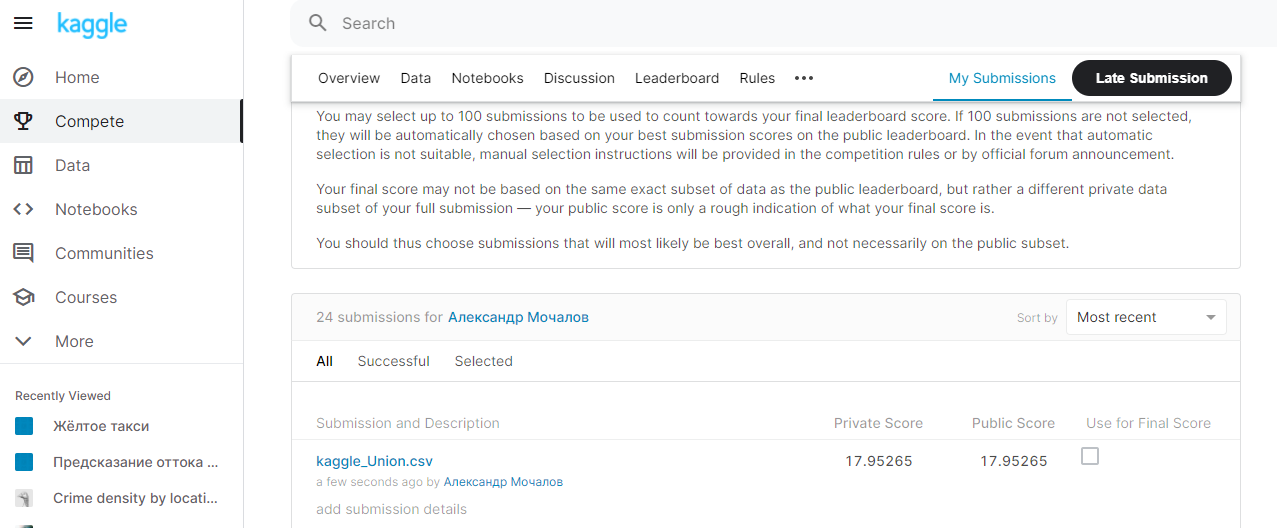

In [62]:
from IPython.display import Image
Image("sub1.png")

### ОБЩИЙ ВЫВОД: как видим результаты улучшились по сравнению с 4ой неделей!!!